# 루브릭 
- klue/bert-base를 pretrained weight 없이 사용해, 모델이 정상적으로 작동하는 것을 확인해보았다.

- 적절한 전처리와 fine-tuning을 통해 val_acc를 90% 이상 달성했다.	

- 클래스 분포를 살펴보고 Bucketing을 수행하여 어떤 효과를 기대할 수 있는지 예상한 결과를 기록했다.

- Bucketing을 수행하여 finetuning 시 연산속도와 모델성능간의 trade-off관계가 발생하는지 여부를 확인하고 분석한 결과를 제시하였다.	

### dataset
1. [Naver sentiment movie corpus v1.0](https://github.com/e9t/nsmc/)


### 적용할 알고리즘
1. [korBert](https://huggingface.co/klue/bert-base)


### 성능 평가 지표  
1. accuracy

## 문제 정의  

 > [klue/bert-base](https://huggingface.co/klue/bert-base)를 사용하여 [NSMC task]((https://github.com/e9t/nsmc/)를 수행하기



## 라이브러리 버전 확인

In [3]:
!pip uninstall transformers -y
!pip install transformers
!pip install evaluate
!pip install tensorflow-datasets -U

Found existing installation: transformers 4.27.1
Uninstalling transformers-4.27.1:
  Successfully uninstalled transformers-4.27.1
  Using cached transformers-4.27.1-py3-none-any.whl (6.7 MB)


In [183]:
from transformers import pipeline

classifier = pipeline('sentiment-analysis', framework='tf')
classifier('We are very happy to include pipeline into the transformers repository.')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


[{'label': 'POSITIVE', 'score': 0.9978194236755371}]

In [184]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import Image

In [185]:
import tensorflow
import numpy
import transformers
import argparse

print(tensorflow.__version__)
print(numpy.__version__)
print(transformers.__version__)
print(argparse.__version__)

2.6.0
1.21.4
4.27.1
1.1


In [186]:
import os
import numpy as np
from argparse import ArgumentParser
import tensorflow as tf
import tensorflow_datasets as tfds
from dataclasses import asdict

In [187]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt, Mecab
from tqdm import tqdm
import tensorflow as tf

In [188]:
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification, AutoConfig

## STEP 1. nsmc 데이터셋 로드 및 확인

### huggingface datasets 이용

* dataset 확인
1. train dataset
  * id, document, label
2. test dataset 
  * id, document, label

In [189]:
from datasets import load_dataset

huggingface_nsmc_dataset = load_dataset('nsmc')
print(huggingface_nsmc_dataset)

Found cached dataset nsmc (/aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 50000
    })
})


In [190]:
huggingface_nsmc_dataset['train']['document'][:5]
huggingface_nsmc_dataset['train']['label'][:5]

['아 더빙.. 진짜 짜증나네요 목소리',
 '흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나',
 '너무재밓었다그래서보는것을추천한다',
 '교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정',
 '사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다']

[0, 1, 0, 0, 1]

## STEP 2. tokenizer와 model 생성

### Huggingface Auto Classes를 이용

* AutoModelForSequenceClassification 클래스 이용하여 Pretrained model 로딩
* Warning  
  Bert가 Text Classification task에 적합한 model head 추가  
  새로운 head에 대한 가중치가 무작위로 초기화 됨  
  추가한 task에 대해서는 train을 해야 한다고 설명

In [191]:
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification

huggingface_tokenizer = AutoTokenizer.from_pretrained('klue/bert-base')
huggingface_model = AutoModelForSequenceClassification.from_pretrained('klue/bert-base', num_labels = 2)
#huggingface_model = AutoModelForSequenceClassification.from_pretrained('klue/bert-base', output_hidden_states = True,num_labels = 2)

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized

In [192]:
huggingface_tokenizer

BertTokenizerFast(name_or_path='klue/bert-base', vocab_size=32000, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [193]:
huggingface_model.__class__
huggingface_model.config.__class__

transformers.models.bert.modeling_bert.BertForSequenceClassification

transformers.models.bert.configuration_bert.BertConfig

In [194]:
huggingface_model.config

BertConfig {
  "_name_or_path": "klue/bert-base",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32000
}

## STEP 3. tokenizer를 활용하여 데이터셋 구성하기

* transformer func  
  * 데이터셋의 개별 항목이 담겨진 딕셔너리를 매개변수로 입력받아서 input_ids, attention_mask 및 token_type_ids 키가 지정된 새로운 딕셔너리를 반환
  * return_token_type_ids = False : token_type_ids 미반환 

#### 1. max_length or longest로 padding 처리 시 

In [158]:
def transform(data):
  return huggingface_tokenizer(
      data['document'],
      truncation = True,
      #padding = 'max_length',
      padding = 'longest',
      return_token_type_ids = False,
      )


examples = huggingface_nsmc_dataset['train'][:5]
examples_transformed = transform(examples)

print(examples)
print()
print(examples_transformed)

{'id': ['9976970', '3819312', '10265843', '9045019', '6483659'], 'document': ['아 더빙.. 진짜 짜증나네요 목소리', '흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나', '너무재밓었다그래서보는것을추천한다', '교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정', '사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다'], 'label': [0, 1, 0, 0, 1]}

{'input_ids': [[2, 1376, 831, 2604, 18, 18, 4229, 9801, 2075, 2203, 2182, 4243, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 1963, 18, 18, 18, 11811, 2178, 2088, 28883, 16516, 2776, 18, 18, 18, 18, 10737, 2156, 2015, 2446, 2232, 6758, 2118, 1380, 6074, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 12381, 3758, 2251, 2615, 18, 18, 7946, 4697, 2259, 1415, 2062, 18, 18, 20609, 4221, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 3734, 2582, 2743, 2029, 2079, 26268, 2255, 2957, 4483, 2116, 21486, 2414, 3771, 5, 29493, 27135, 795, 15882, 2052, 2015, 2154, 190

#### 2. dynamic padding 처리 시 
* padding 생략
* 모든 data를 최대길이로 padding 하는 것은 비효율적임
* 배치(batch) 형태로 실행할 때 data에 채우는 것(padding)이 효과적임.
  * 전체 데이터셋에서의 최대 길이가 아니라 해당 배치(batch) 내에서의 최대 길이로 채우기(padding) 처리.
  * 입력의 길이가 매우 가변적일 때 많은 시간과 처리 능력을 절약!!


In [195]:
def transform(data):
  return huggingface_tokenizer(
      data['document'],
      truncation = True,
#      padding = 'max_length',
      return_token_type_ids = False,
      )


examples = huggingface_nsmc_dataset['test'][:5]
examples_transformed = transform(examples)

print(examples)
print()
print(examples_transformed)

{'id': ['6270596', '9274899', '8544678', '6825595', '6723715'], 'document': ['굳 ㅋ', 'GDNTOPCLASSINTHECLUB', '뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아', '지루하지는 않은데 완전 막장임... 돈주고 보기에는....', '3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??'], 'label': [1, 0, 0, 0, 0]}

{'input_ids': [[2, 618, 191, 3], [2, 43, 2134, 2111, 11216, 2325, 2108, 21072, 2238, 14948, 2111, 2081, 2109, 10990, 2237, 2309, 2206, 3], [2, 1097, 2275, 1504, 20609, 2031, 2073, 18, 18, 18, 18, 8170, 2043, 1380, 3683, 3633, 2532, 5708, 2259, 14236, 3614, 9958, 3], [2, 9734, 2205, 2118, 2259, 1380, 2073, 2147, 5124, 22657, 2289, 18, 18, 18, 850, 2223, 2088, 1160, 12551, 2259, 18, 18, 18, 18, 3], [2, 23, 2134, 2154, 3614, 2359, 6186, 1156, 5437, 558, 1572, 2069, 2436, 2147, 18, 18, 1460, 23, 2134, 2200, 8678, 1545, 17874, 2138, 5153, 2205, 2318, 1889, 2321, 35, 35, 3]], 'attention_mask': [[1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

#### map 을 이용하여 tokenization 진행
* 특정 데이터를 dataset 객체로 유지하기 위해 Dataset.map() 메서드를 사용
* batched=True를 사용
  * 함수가 각 요소에 개별적으로 적용되지 않고 데이터셋의 하부집합, 즉 각 배치(batch) 내에 존재하는 모든 요소들에 한꺼번에 적용

In [196]:
encoded_dataset = huggingface_nsmc_dataset.map(transform, batched=True)

#encoded_dataset = encoded_dataset.remove_columns(['id','document'])
#encoded_dataset = encoded_dataset.remove_columns(['label'])
#encoded_dataset = encoded_dataset.with_format('torch')

Loading cached processed dataset at /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-0bd50172299e8e6d.arrow
Loading cached processed dataset at /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-9b598f8623c74919.arrow


In [197]:
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label', 'input_ids', 'attention_mask'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label', 'input_ids', 'attention_mask'],
        num_rows: 50000
    })
})

#### 1. max_length or longest로 padding 처리 시 

In [161]:
## 고정패팅
len(encoded_dataset['train'][3]['input_ids'])
len(encoded_dataset['test'][3]['input_ids'])

105

96

#### 2. dynamic padding 처리 시 

In [198]:
## 가변 패팅
len(encoded_dataset['train'][3]['input_ids'])
len(encoded_dataset['test'][3]['input_ids'])

17

25

#### 문장 길이 분포

In [199]:
train = encoded_dataset["train"][:]
train = {k: v for k, v in train.items() if k not in ["id", "document"]}
set([len(x) for x in train["input_ids"]])

test = encoded_dataset["test"][:]
test = {k: v for k, v in test.items() if k not in ["id", "document"]}
set([len(x) for x in test["input_ids"]])

{2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 122,
 123,
 124,
 127,
 134,
 142}

{2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 114,
 115,
 116,
 118,
 119,
 120,
 122}

#### 동적 패딩(Dynamic padding)
 * 전체 요소들을 배치(batch)로 분리할 때 가장 긴 요소의 길이로 모든 예제를 채우는(padding)
 * 전체 데이터셋이 아닌 개별 배치(batch)에 대해서 별도로 패딩(padding)을 수행하여 과도하게 긴 입력으로 인한 과도한 패딩(padding) 작업을 방지하기 위함
 * 샘플들을 함께 모아서 지정된 크기의 배치(batch)로 구성하는 역할을 하는 함수를 콜레이트 함수(collate function)
 * DataCollatorWithPadding  
   배치(batch)로 분리하려는 데이터셋의 요소 각각에 대해서 정확한 수의 패딩(padding)을 적용

In [200]:
#from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=huggingface_tokenizer)
#data_collator = DataCollatorWithPadding(tokenizer=huggingface_tokenizer,return_tensors='tf')


#### data_collator test

In [201]:
samples = encoded_dataset["train"][:32]
samples = {k: v for k, v in samples.items() if k not in ["id", "document"]}
[len(x) for x in samples["input_ids"]]

[13,
 25,
 3,
 17,
 36,
 29,
 14,
 61,
 15,
 31,
 15,
 32,
 21,
 30,
 32,
 12,
 39,
 18,
 26,
 21,
 23,
 13,
 69,
 16,
 12,
 33,
 14,
 9,
 6,
 26,
 29,
 13]

In [202]:
batch = data_collator(samples)
{k: v.shape for k, v in batch.items()}

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'input_ids': torch.Size([32, 69]),
 'attention_mask': torch.Size([32, 69]),
 'labels': torch.Size([32])}

## STEP 4. Train 및 Evaluation 진행

### Trainer Class를 활용한 학습 진행

#### 1. max_length or longest로 padding 처리 시 

* TrainingArguments를 통해 학습 관련 설정 지정

In [162]:
# Trainer을 활용하는 형태로 모델 재생성
from transformers import Trainer, TrainingArguments

output_dir = './data'

training_arguments = TrainingArguments(
    output_dir, # output이 저장될 경로
    evaluation_strategy="steps", #evaluation하는 빈도
    learning_rate = 2e-5, #learning_rate
    per_device_train_batch_size = 32, # 각 device 당 batch size
    per_device_eval_batch_size = 32, # evaluation 시에 batch size
    num_train_epochs = 2, # train 시킬 총 epochs
    weight_decay = 0.01, # weight decay
#    group_by_length = True,
    save_strategy = 'steps'
   )

* compute_metrics 메소드

In [163]:
#from datasets import load_metric
import numpy as np
import evaluate

#metric = load_metric('accuracy')
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):    
    predictions,labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references = labels)

* Trainer에 model, arguments, train_dataset, eval_dataset, compute_metrics를 넣고 train을 진행

In [164]:
trainer = Trainer(
    model=huggingface_model,                           # 학습시킬 model
    args=training_arguments,                  # TrainingArguments을 통해 설정한 arguments
    train_dataset=encoded_dataset['train'],    # training dataset
    eval_dataset=encoded_dataset['test'],       # evaluation dataset
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    tokenizer=huggingface_tokenizer,
)

In [51]:
trainer.train()

/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Accuracy
500,0.348500,0.303762,0.872520
1000,0.289400,0.295090,0.872840
1500,0.282500,0.263416,0.889220
2000,0.272400,0.258611,0.893780
2500,0.264500,0.258808,0.893300
3000,0.250900,0.254405,0.893940
3500,0.249200,0.241779,0.900060
4000,0.259400,0.238713,0.900740
4500,0.246500,0.236683,0.902020
5000,0.210200,0.246748,0.902040


TrainOutput(global_step=9376, training_loss=0.22494078170724288, metrics={'train_runtime': 11552.9562, 'train_samples_per_second': 25.967, 'train_steps_per_second': 0.812, 'total_flos': 1.583527308907776e+16, 'train_loss': 0.22494078170724288, 'epoch': 2.0})

* evaluation 진행

In [165]:
len(encoded_dataset['test'][0]['input_ids'])

96

In [57]:
trainer.evaluate(encoded_dataset['test'])

print("완료")

{'eval_loss': 0.24729055166244507,
 'eval_accuracy': 0.90762,
 'eval_runtime': 340.5475,
 'eval_samples_per_second': 146.822,
 'eval_steps_per_second': 4.59,
 'epoch': 2.0}

완료


*  predict 진행

In [166]:
predicts = trainer.predict(encoded_dataset['test'])
predicts

PredictionOutput(predictions=array([[-2.1016142 ,  2.5430646 ],
       [-0.55479914,  1.1290125 ],
       [ 1.5495117 , -1.1944097 ],
       ...,
       [ 0.11867686,  0.37726644],
       [ 3.7675648 , -3.4558897 ],
       [ 1.9369565 , -1.2857406 ]], dtype=float32), label_ids=array([1, 0, 0, ..., 0, 0, 0]), metrics={'test_loss': 0.24729055166244507, 'test_accuracy': 0.90762, 'test_runtime': 340.3341, 'test_samples_per_second': 146.914, 'test_steps_per_second': 4.593})

In [167]:
predicts.predictions.shape, predicts.label_ids.shape

((50000, 2), (50000,))

In [168]:
preds = np.argmax(predicts.predictions, axis=-1)

In [169]:
#from datasets import load_metric
import evaluate

#metric = load_metric("glue", "mrpc")
metric = evaluate.load("accuracy")
metric.compute(predictions=preds, references=predicts.label_ids)

{'accuracy': 0.90762}

* 모델 저장

In [64]:
huggingface_model.save_pretrained('nsmc_model/bert-base')
huggingface_tokenizer.save_pretrained('nsmc_model/bert-base')

('nsmc_model/bert-base/tokenizer_config.json',
 'nsmc_model/bert-base/special_tokens_map.json',
 'nsmc_model/bert-base/vocab.txt',
 'nsmc_model/bert-base/added_tokens.json',
 'nsmc_model/bert-base/tokenizer.json')

In [157]:
huggingface_tokenizer = AutoTokenizer.from_pretrained('nsmc_model/bert-base')
huggingface_model = AutoModelForSequenceClassification.from_pretrained('nsmc_model/bert-base')

## 가변 패팅

#### 2. dynamic padding 처리 시

* TrainingArguments를 통해 학습 관련 설정 지정
> group_by_length : False (bucketing 수행)  

In [205]:
# Trainer을 활용하는 형태로 모델 재생성
from transformers import Trainer, TrainingArguments

output_dir = './data'

training_arguments = TrainingArguments(
    output_dir, # output이 저장될 경로
    evaluation_strategy="steps", #evaluation하는 빈도
    learning_rate = 2e-5, #learning_rate
    per_device_train_batch_size = 32, # 각 device 당 batch size
    per_device_eval_batch_size = 32, # evaluation 시에 batch size
    num_train_epochs = 2, # train 시킬 총 epochs
    weight_decay = 0.01, # weight decay
    group_by_length = False,
    save_strategy = 'steps'
   )

* TrainingArguments를 통해 학습 관련 설정 지정
> group_by_length : True (bucketing 수행 - 문장 길이에 따라 같은 길이 끼리 묶어서 할당)  
> group_by_length (bool, optional, defaults to False) — Whether or not to group together samples of roughly the same length in the training dataset (to minimize padding applied and be more efficient). Only useful if applying dynamic padding.

In [123]:
# Trainer을 활용하는 형태로 모델 재생성
from transformers import Trainer, TrainingArguments

output_dir = './data'

training_arguments = TrainingArguments(
    output_dir, # output이 저장될 경로
    evaluation_strategy="steps", #evaluation하는 빈도
    learning_rate = 2e-5, #learning_rate
    per_device_train_batch_size = 32, # 각 device 당 batch size
    per_device_eval_batch_size = 32, # evaluation 시에 batch size
    num_train_epochs = 2, # train 시킬 총 epochs
    weight_decay = 0.01, # weight decay
    group_by_length = True,
    save_strategy = 'steps'
   )

* compute_metrics 메소드

In [206]:
#from datasets import load_metric
import numpy as np
import evaluate

#metric = load_metric('accuracy')
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):    
    predictions,labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references = labels)

* Trainer에 model, arguments, train_dataset, eval_dataset, compute_metrics를 넣고 train을 진행

In [207]:
trainer = Trainer(
    model=huggingface_model,                           # 학습시킬 model
    args=training_arguments,                  # TrainingArguments을 통해 설정한 arguments
    train_dataset=encoded_dataset['train'],    # training dataset
    eval_dataset=encoded_dataset['test'],       # evaluation dataset
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    tokenizer=huggingface_tokenizer,
)

#### group_by_length : False (bucketing 수행)  시

In [208]:
trainer.train()

/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,0.361600,0.319819,0.865900
1000,0.290900,0.276954,0.883520
1500,0.282300,0.268595,0.888980
2000,0.270700,0.300485,0.872540
2500,0.263500,0.262609,0.893240
3000,0.256000,0.267795,0.889640
3500,0.251400,0.244261,0.900960
4000,0.258000,0.249537,0.899660
4500,0.246500,0.236889,0.902140
5000,0.208100,0.256768,0.904040


TrainOutput(global_step=9376, training_loss=0.22595171798211316, metrics={'train_runtime': 8535.0351, 'train_samples_per_second': 35.149, 'train_steps_per_second': 1.099, 'total_flos': 1.12945353845568e+16, 'train_loss': 0.22595171798211316, 'epoch': 2.0})

#### group_by_length : True (bucketing 수행 - 문장 길이에 따라 같은 길이 끼리 묶어서 할당) 시

In [126]:
trainer.train()

/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,0.350600,0.342195,0.859500
1000,0.290600,0.277589,0.881180
1500,0.283300,0.270469,0.886680
2000,0.272900,0.275917,0.885140
2500,0.264900,0.259461,0.891360
3000,0.251800,0.247356,0.897920
3500,0.250900,0.254483,0.896240
4000,0.258800,0.240560,0.901400
4500,0.246400,0.236876,0.901440
5000,0.204700,0.258626,0.902220


TrainOutput(global_step=9376, training_loss=0.22496741786344873, metrics={'train_runtime': 6199.5218, 'train_samples_per_second': 48.391, 'train_steps_per_second': 1.512, 'total_flos': 3617678344554240.0, 'train_loss': 0.22496741786344873, 'epoch': 2.0})

* evaluation 진행

In [131]:
len(encoded_dataset['test'][0]['input_ids'])

4

In [132]:
trainer.evaluate(encoded_dataset['test'])

print("완료")

{'eval_loss': 0.24855229258537292,
 'eval_accuracy': 0.90688,
 'eval_runtime': 241.4668,
 'eval_samples_per_second': 207.068,
 'eval_steps_per_second': 6.473,
 'epoch': 2.0}

완료


*  predict 진행

In [133]:
predicts = trainer.predict(encoded_dataset['test'])
predicts

PredictionOutput(predictions=array([[-2.5670576 ,  1.743356  ],
       [-0.97058636,  0.56206685],
       [ 2.0569272 , -1.8019967 ],
       ...,
       [ 0.35250664, -0.2036135 ],
       [ 3.7146888 , -3.6267927 ],
       [ 1.7800817 , -1.7072463 ]], dtype=float32), label_ids=array([1, 0, 0, ..., 0, 0, 0]), metrics={'test_loss': 0.24855229258537292, 'test_accuracy': 0.90688, 'test_runtime': 238.9505, 'test_samples_per_second': 209.248, 'test_steps_per_second': 6.541})

In [134]:
predicts.predictions.shape, predicts.label_ids.shape

((50000, 2), (50000,))

In [135]:
preds = np.argmax(predicts.predictions, axis=-1)

In [136]:
#from datasets import load_metric
import evaluate

#metric = load_metric("glue", "mrpc")
metric = evaluate.load("accuracy")
metric.compute(predictions=preds, references=predicts.label_ids)

{'accuracy': 0.90688}

* 모델 저장

In [138]:
huggingface_model.save_pretrained('nsmc_model/bert-base-dynamic')
huggingface_tokenizer.save_pretrained('nsmc_model/bert-base-dynamic')

('nsmc_model/bert-base-dynamic/tokenizer_config.json',
 'nsmc_model/bert-base-dynamic/special_tokens_map.json',
 'nsmc_model/bert-base-dynamic/vocab.txt',
 'nsmc_model/bert-base-dynamic/added_tokens.json',
 'nsmc_model/bert-base-dynamic/tokenizer.json')

In [ ]:
huggingface_tokenizer = AutoTokenizer.from_pretrained('nsmc_model/bert-base-dynamic')
huggingface_model = AutoModelForSequenceClassification.from_pretrained('nsmc_model/bert-base-dynamic')

## STEP 5. 모델 로드 및 테스트 

#### TextClassificationPipeline
* 모델의 예측값이 소프트맥스 함수를 통과한 후의 값인 레이블 별 스코어 임

In [68]:
huggingface_nsmc_dataset['test']['document'][100:106]
huggingface_nsmc_dataset['test']['label'][100:106]

['걸작은 몇안되고 졸작들만 넘쳐난다.',
 '이렇게 지겨울수가',
 'ost... 정말 좋았어요. 영화 자체도.. 의문은 남지만 ㅎㅎ',
 '펑퍼짐한 건빵바지(카고)를 입고 오도바이탈때 입는 잠바 같은 것을 입은 주인공겸 감독이 앞차기 옆차기 뒷차기 앞돌려차기등의 기술을 구사해 악당을 소탕하는 영화 주먹질도 하지만 앞차기와 옆차기의 비중이 크다',
 '솔직히 생각보다 재밌어서 놀랐다... 이거 개봉하고 낸린줄도 모르고...ㅠ ㅠ 이제서야 봤네... 정말 두 사람의 커플댄스는... 명장면이다... 생각할수록 아쉽다... 단순 sm상업영화라고 생각하기엔... 두 사람의 춤이 너무 인상적이다...',
 '이거 평점보니까 알바고용하는데 제작비보다 많이들어갔겠어요 정말 재미라고는 찾아볼 수 없고 특히 마지막에 여자애가 경상도사람이 들으면 코웃음 칠만큼 어색한 사투리로 엄마한테 말할때는 그나마 잡히던 감정도 깨져버렸습니다']

[0, 0, 1, 0, 1, 0]

#### Pretrained model

In [215]:
from transformers import TextClassificationPipeline

# 로드하기
loaded_tokenizer = AutoTokenizer.from_pretrained('klue/bert-base')
loaded_model = AutoModelForSequenceClassification.from_pretrained('klue/bert-base')

text_classifier = TextClassificationPipeline(
    tokenizer=loaded_tokenizer, 
    model=loaded_model, 
#    framework='tf',
    return_all_scores=True
)

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized

In [216]:
text_classifier('걸작은 몇안되고 졸작들만 넘쳐난다.')[0]

[{'label': 'LABEL_0', 'score': 0.5378297567367554},
 {'label': 'LABEL_1', 'score': 0.46217024326324463}]

In [217]:
text_classifier('ost... 정말 좋았어요. 영화 자체도.. 의문은 남지만 ㅎㅎ')[0]

[{'label': 'LABEL_0', 'score': 0.6520986557006836},
 {'label': 'LABEL_1', 'score': 0.3479013741016388}]

In [218]:
text_classifier('펑퍼짐한 건빵바지(카고)를 입고 오도바이탈때 입는 잠바 같은 것을 입은 주인공겸 감독이 앞차기 옆차기 뒷차기 앞돌려차기등의 기술을 구사해 악당을 소탕하는 영화 주먹질도 하지만 앞차기와 옆차기의 비중이 크다',)[0]

[{'label': 'LABEL_0', 'score': 0.5777747631072998},
 {'label': 'LABEL_1', 'score': 0.4222252666950226}]

In [219]:
text_classifier('이거 평점보니까 알바고용하는데 제작비보다 많이들어갔겠어요 정말 재미라고는 찾아볼 수 없고 특히 마지막에 여자애가 경상도사람이 들으면 코웃음 칠만큼 어색한 사투리로 엄마한테 말할때는 그나마 잡히던 감정도 깨져버렸습니다')[0]

[{'label': 'LABEL_0', 'score': 0.5022687315940857},
 {'label': 'LABEL_1', 'score': 0.4977312684059143}]

#### Fine-tuning model

#### 1. max_length or longest로 padding 처리 시 

In [220]:
from transformers import TextClassificationPipeline

# 로드하기
loaded_tokenizer = AutoTokenizer.from_pretrained('nsmc_model/bert-base')
loaded_model = AutoModelForSequenceClassification.from_pretrained('nsmc_model/bert-base')

text_classifier = TextClassificationPipeline(
    tokenizer=loaded_tokenizer, 
    model=loaded_model, 
#    framework='tf',
    return_all_scores=True
)

In [221]:
text_classifier('걸작은 몇안되고 졸작들만 넘쳐난다.')[0]

[{'label': 'LABEL_0', 'score': 0.9982321858406067},
 {'label': 'LABEL_1', 'score': 0.0017678668955340981}]

In [222]:
text_classifier('ost... 정말 좋았어요. 영화 자체도.. 의문은 남지만 ㅎㅎ')[0]

[{'label': 'LABEL_0', 'score': 0.00450678588822484},
 {'label': 'LABEL_1', 'score': 0.9954931735992432}]

In [223]:
text_classifier('펑퍼짐한 건빵바지(카고)를 입고 오도바이탈때 입는 잠바 같은 것을 입은 주인공겸 감독이 앞차기 옆차기 뒷차기 앞돌려차기등의 기술을 구사해 악당을 소탕하는 영화 주먹질도 하지만 앞차기와 옆차기의 비중이 크다',)[0]

[{'label': 'LABEL_0', 'score': 0.30961325764656067},
 {'label': 'LABEL_1', 'score': 0.6903867721557617}]

In [224]:
text_classifier('이거 평점보니까 알바고용하는데 제작비보다 많이들어갔겠어요 정말 재미라고는 찾아볼 수 없고 특히 마지막에 여자애가 경상도사람이 들으면 코웃음 칠만큼 어색한 사투리로 엄마한테 말할때는 그나마 잡히던 감정도 깨져버렸습니다')[0]

[{'label': 'LABEL_0', 'score': 0.9991514682769775},
 {'label': 'LABEL_1', 'score': 0.0008485556463710964}]

#### 2. dynamic padding 처리 시

In [225]:
from transformers import TextClassificationPipeline

# 로드하기
loaded_tokenizer = AutoTokenizer.from_pretrained('nsmc_model/bert-base-dynamic')
loaded_model = AutoModelForSequenceClassification.from_pretrained('nsmc_model/bert-base-dynamic')

text_classifier = TextClassificationPipeline(
    tokenizer=loaded_tokenizer, 
    model=loaded_model, 
#    framework='tf',
    return_all_scores=True
)

In [226]:
text_classifier('걸작은 몇안되고 졸작들만 넘쳐난다.')[0]

[{'label': 'LABEL_0', 'score': 0.9980570673942566},
 {'label': 'LABEL_1', 'score': 0.0019428539089858532}]

In [227]:
text_classifier('ost... 정말 좋았어요. 영화 자체도.. 의문은 남지만 ㅎㅎ')[0]

[{'label': 'LABEL_0', 'score': 0.00419238256290555},
 {'label': 'LABEL_1', 'score': 0.9958076477050781}]

In [228]:
text_classifier('펑퍼짐한 건빵바지(카고)를 입고 오도바이탈때 입는 잠바 같은 것을 입은 주인공겸 감독이 앞차기 옆차기 뒷차기 앞돌려차기등의 기술을 구사해 악당을 소탕하는 영화 주먹질도 하지만 앞차기와 옆차기의 비중이 크다',)[0]

[{'label': 'LABEL_0', 'score': 0.515796422958374},
 {'label': 'LABEL_1', 'score': 0.484203577041626}]

In [229]:
text_classifier('이거 평점보니까 알바고용하는데 제작비보다 많이들어갔겠어요 정말 재미라고는 찾아볼 수 없고 특히 마지막에 여자애가 경상도사람이 들으면 코웃음 칠만큼 어색한 사투리로 엄마한테 말할때는 그나마 잡히던 감정도 깨져버렸습니다')[0]

[{'label': 'LABEL_0', 'score': 0.9989676475524902},
 {'label': 'LABEL_1', 'score': 0.0010323687456548214}]

## 회고

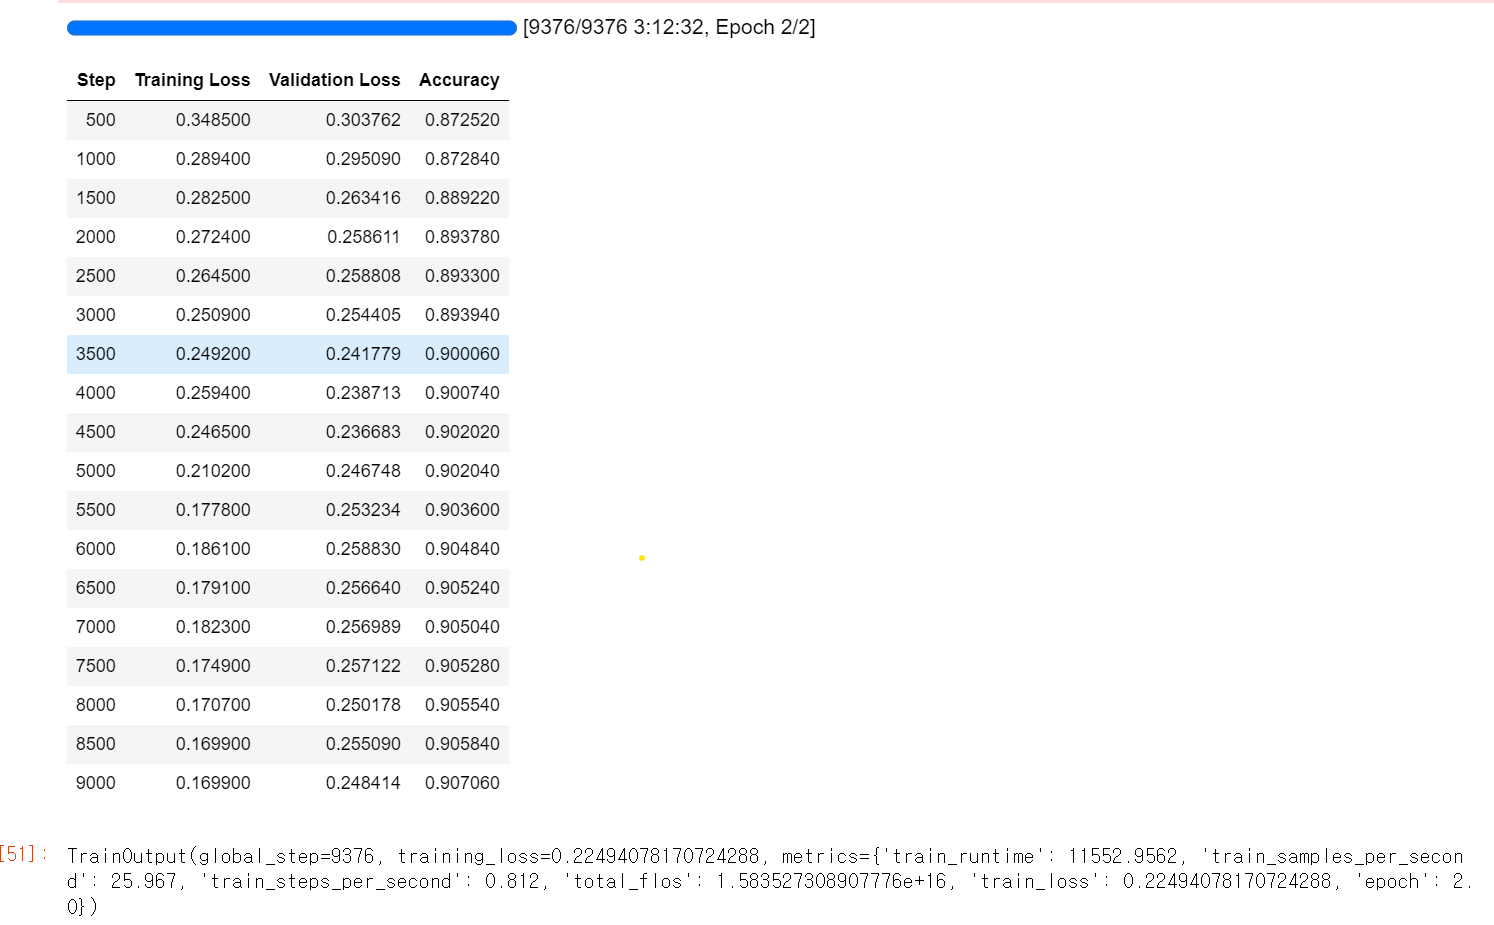

In [230]:
Image(filename='./data/fixed_padding.png') 

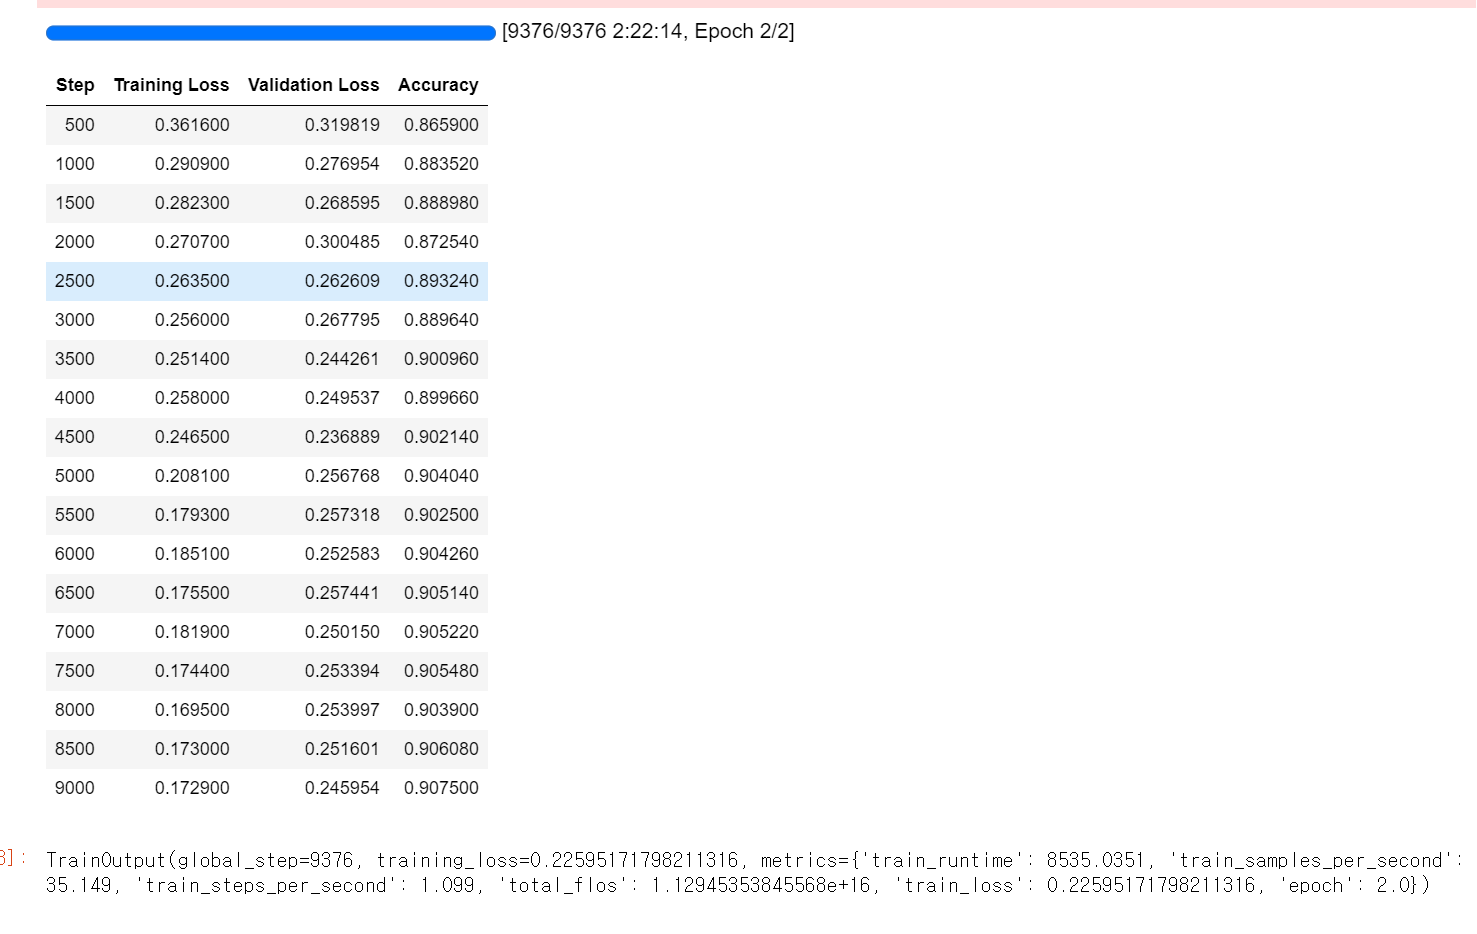

In [231]:
Image(filename='./data/dynamic_notgroup_padding.png') 

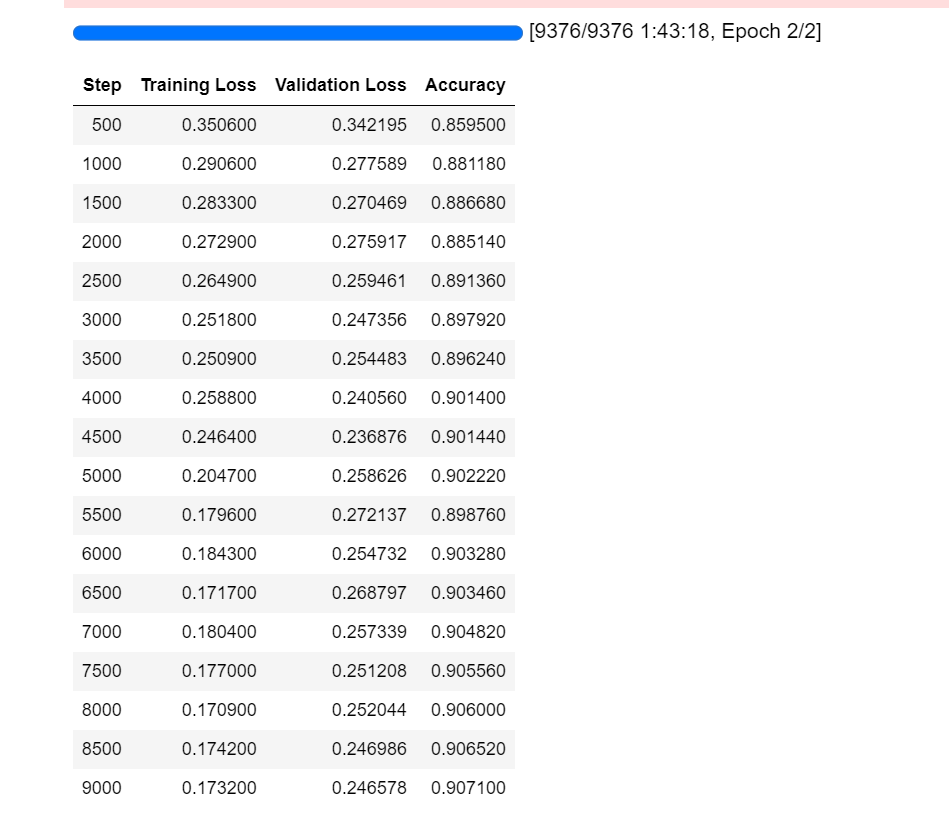

In [145]:
Image(filename='./data/dynamic_padding.png') 

## 참고 문헌
* [Transformers (신경망 언어모델 라이브러리 강좌)](https://wikidocs.net/166802)